# This ia a notebook to understand Optimal transport pathways on SO3 space

In [2]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from geomstats.geometry.special_orthogonal import SpecialOrthogonal

# Initialize SO(3) geometry
so3 = SpecialOrthogonal(n=3)

In [16]:
# generate two random distributions of rotations
def sample_so3(num_samples):
    """Generate random samples from SO(3)."""
    return so3.random_uniform(n_samples=num_samples)

num_samples = 2
rotations_source = sample_so3(num_samples)  # Source distribution
rotations_target = sample_so3(num_samples)  # Target distribution



In [17]:
# compute the pairwise geodesic distances between the two distributions(cost matrix)
def geodesic_distance_matrix(rotations1, rotations2, metric):
    """
    Compute the pairwise geodesic distance between two sets of rotations.
    
    Parameters:
    - rotations1: Array of rotation matrices from the first distribution.
    - rotations2: Array of rotation matrices from the second distribution.
    - metric: The Riemannian metric associated with the manifold.
    
    Returns:
    - cost_matrix: Pairwise geodesic distance matrix.
    """
    n1 = len(rotations1)
    n2 = len(rotations2)
    cost_matrix = np.zeros((n1, n2))
    for i in range(n1):
        for j in range(n2):
            cost_matrix[i, j] = metric.dist(rotations1[i], rotations2[j])
    return cost_matrix

# Compute the geodesic distance cost matrix
cost_matrix = geodesic_distance_matrix(rotations_source, rotations_target, so3.metric)



In [18]:
# optimal transport using the Sinkhorn-Knopp algorithm with emtropy regularization
def sinkhorn_knopp(a, b, cost_matrix, reg=0.01, num_iters=100):
    """Solve OT using Sinkhorn algorithm."""
    K = np.exp(-cost_matrix / reg)
    u = np.ones_like(a)
    v = np.ones_like(b)
    
    for _ in range(num_iters):
        u = a / (K @ v)
        v = b / (K.T @ u)
    
    transport_plan = np.diag(u) @ K @ np.diag(v)
    return transport_plan

# Uniform distributions
a = np.ones(num_samples) / num_samples
b = np.ones(num_samples) / num_samples

transport_plan = sinkhorn_knopp(a, b, cost_matrix)



In [19]:
print("Optimal Transport Plan:")
print(transport_plan)

Optimal Transport Plan:
[[4.97500000e-01 4.02626245e-13]
 [2.50000000e-03 5.00000000e-01]]


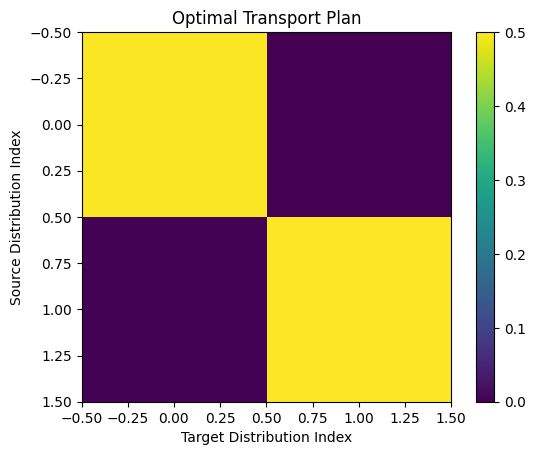

In [20]:
#visualize the transport plan
import matplotlib.pyplot as plt

plt.imshow(transport_plan, cmap="viridis")
plt.colorbar()
plt.title("Optimal Transport Plan")
plt.xlabel("Target Distribution Index")
plt.ylabel("Source Distribution Index")
plt.show()


In [24]:
def interpolate_rotations(rot1, rot2, t):
    """Geodesic interpolation between two rotations."""
    return so3.exp(t * so3.log(rot2, rot1), rot1)

for i, j in zip(*np.where(transport_plan > 1e-2)):
    print(f"Interpolating between rotation {i} and {j}")
    #interpolate_rotations={}
    for t in np.linspace(0, 1, 200):
        interpolated_rotation = interpolate_rotations(rotations_source[i], rotations_target[j], t)
        #print(f"t={t}: {interpolated_rotation}")

# Example interpolation
#t_values = np.linspace(0, 1, 2000)
##interpolated_rotations = [interpolate_rotations(rotations_source[i], rotations_target[j], t)
#                         for i, j, t in zip(*np.where(transport_plan > 1e-2), t_values)]

            


Interpolating between rotation 0 and 0
Interpolating between rotation 1 and 1


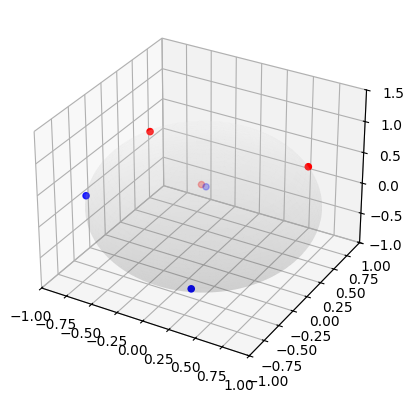

In [25]:
visualize_hypersphere(points=rotations_source[1],traj=interpolated_rotation)

In [11]:
print(len(interpolated_rotations))
print(interpolated_rotations[0])

164
[[-0.91535138  0.04105032  0.400558  ]
 [ 0.3692684  -0.311041    0.87572504]
 [ 0.16053876  0.94950954  0.26955322]]


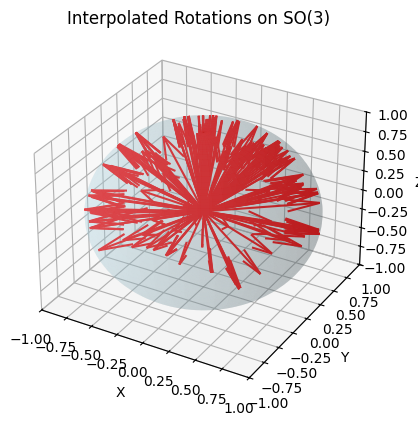

In [12]:

# Visualize rotations as vectors on a sphere
def visualize_interpolations(rotations):
    """
    Visualize rotations on a 3D sphere.
    
    Parameters:
    - rotations: List of rotation matrices.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    
    # Plot the sphere
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, color="lightblue", alpha=0.2)
    
    # Plot rotation vectors
    for rot in rotations:
        vector = rot[:, 2]  # Plot the Z-axis direction of the rotation
        ax.quiver(0, 0, 0, vector[0], vector[1], vector[2], color="r")
    
    # Format the plot
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_title("Interpolated Rotations on SO(3)")
    plt.show()


#
visualize_interpolations(interpolated_rotations)

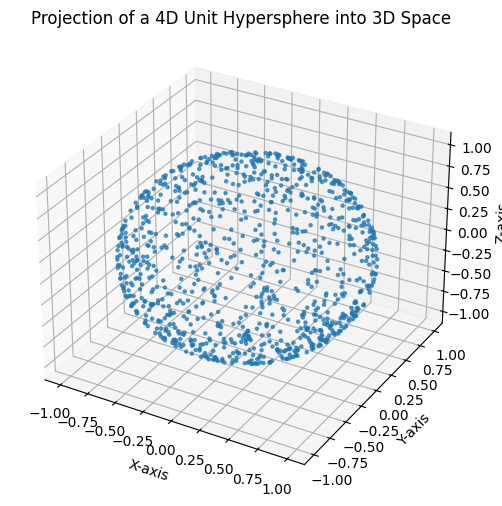

In [13]:
import torch

def visualize_sphere_extrinsic(num_points: int = 1000):
  # Number of points to sample on the hypersphere
  num_points = 1000

  # Dimension of the hypersphere (4D in this case)
  n_dim = 3

  # Generate random points from a standard normal distribution
  x = torch.randn(num_points, n_dim)

  # Normalize each point to lie on the unit hypersphere
  x_projected = x / x.norm(dim=1, keepdim=True)

  # Convert tensors to numpy arrays for plotting
  x_np = x_projected.numpy()

  # Set up the 3D plot
  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111, projection='3d')

  # Plot the projected points
  ax.scatter(x_np[:, 0], x_np[:, 1], x_np[:, 2], s=5, alpha=0.7)

  # Label the axes
  ax.set_xlabel('X-axis')
  ax.set_ylabel('Y-axis')
  ax.set_zlabel('Z-axis')
  ax.set_title('Projection of a 4D Unit Hypersphere into 3D Space')

  # Show the plot
  plt.show()

visualize_sphere_extrinsic(num_points=10000)

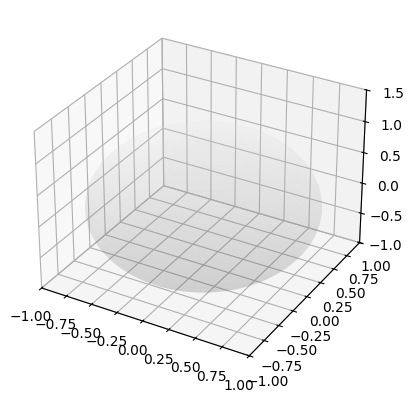

In [14]:
def visualize_hypersphere(points=None, traj=None):
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')

  # Make data
  u = torch.linspace(0, 2 * np.pi, 100)
  v = torch.linspace(0, np.pi, 100)
  x = 1 * torch.outer(torch.cos(u), torch.sin(v))
  y = 1 * torch.outer(torch.sin(u), torch.sin(v))
  z = 1 * torch.outer(torch.ones(u.size()), torch.cos(v))

  # Plot the surface
  ax.plot_surface(x, y, z, cmap="Greys_r", zorder=1, alpha=0.1)

  if points is not None:
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='r', marker='o',
               s=20, zorder=2)
  if traj is not None:
    ax.scatter(traj[:, 0], traj[:, 1], traj[:, 2], color="blue", marker='o')

  # Set an equal aspect ratio
  ax.set_aspect('auto')
  # set z axis limit
  ax.set_zlim(-1, 1.5)
  # set x axis limit
  ax.set_xlim(-1, 1)
  # set y axis limit
  ax.set_ylim(-1, 1)

  plt.show()

visualize_hypersphere()

TypeError: list indices must be integers or slices, not tuple

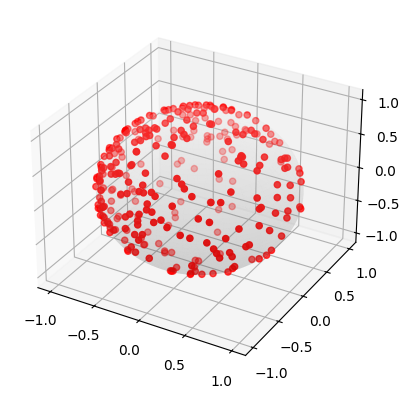

In [15]:
visualize_hypersphere(points=rotations_source, traj=interpolated_rotations)